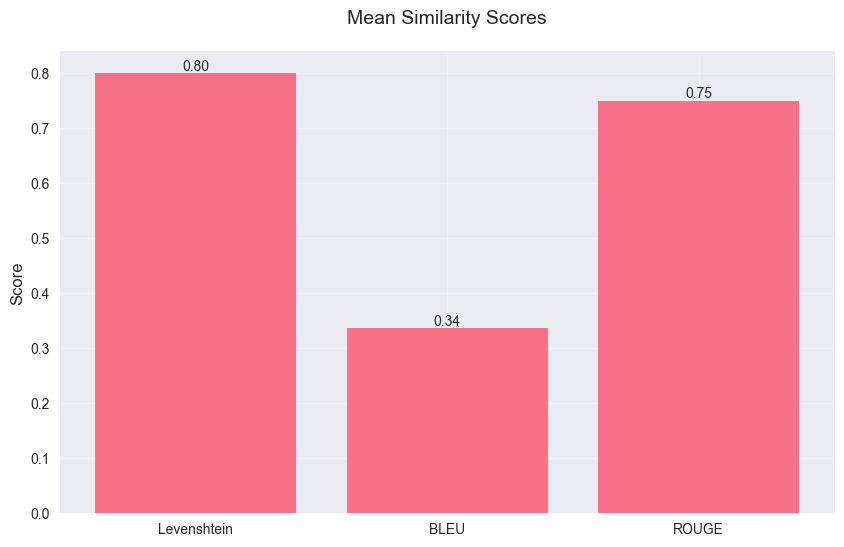

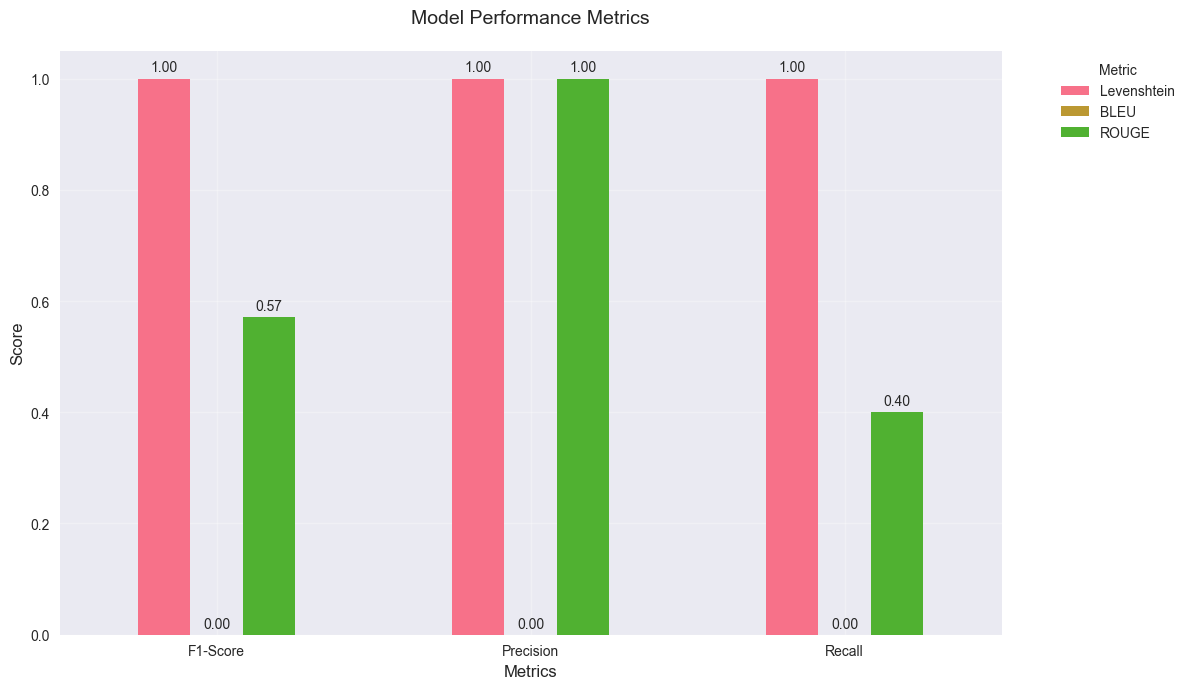

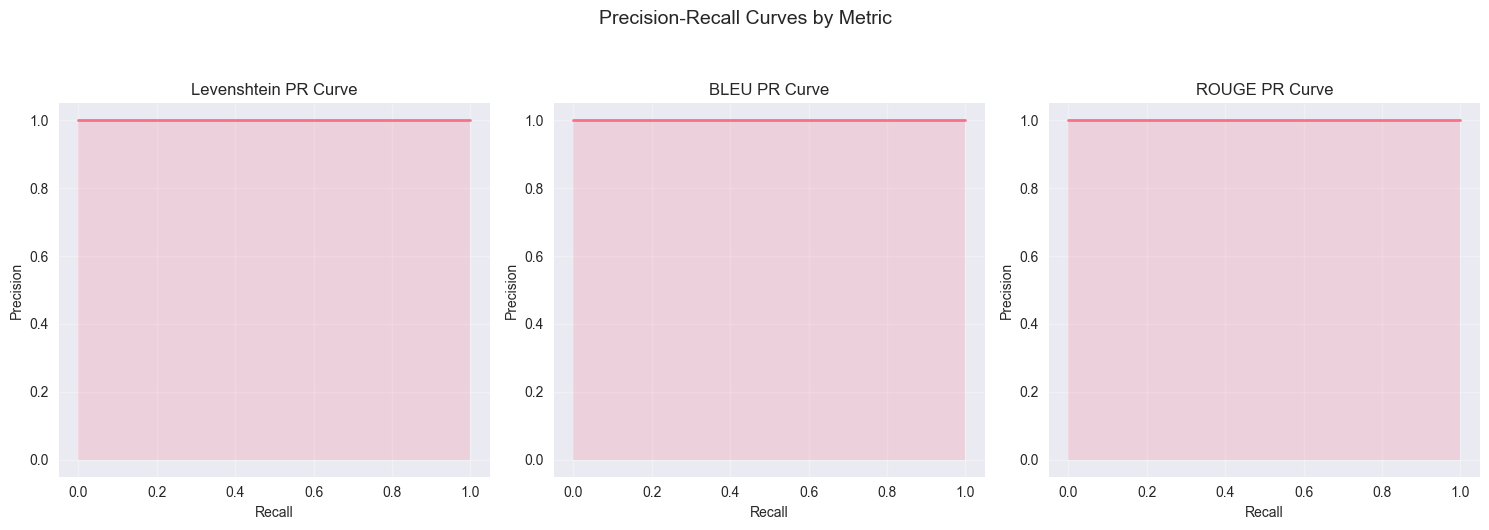

In [14]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from Levenshtein import ratio as levenshtein_ratio
import matplotlib.pyplot as plt
import nltk
import seaborn as sns


plt.style.use('seaborn-v0_8') 
sns.set_palette("husl")

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')


rouge_scorer_instance = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
smoother = SmoothingFunction()


THRESHOLD = 0.7


dummy_data = {
    "annotated_labels": [
        "machine learning is interesting",
        "natural language processing",
        "deep neural networks", 
        "computer vision applications",
        "data science methods"
    ],
    "Mistral_answer": [
        "machine learning is fun",
        "natural language understanding",
        "deep neural networks",
        "computer vision systems",
        "data science techniques"
    ]
}
df = pd.DataFrame(dummy_data)


levenshtein_scores, bleu_scores, rouge_scores = [], [], []
levenshtein_bool, bleu_bool, rouge_bool = [], [], []


for index, row in df.iterrows():
    ann = str(row["annotated_labels"])
    gen = str(row["Mistral_answer"])
    
    
    lev_score = levenshtein_ratio(gen, ann)
    levenshtein_scores.append(lev_score)
    levenshtein_bool.append(lev_score > THRESHOLD)
    
    
    reference = nltk.word_tokenize(ann.lower())
    candidate = nltk.word_tokenize(gen.lower())
    bleu_score = sentence_bleu([reference], candidate, smoothing_function=smoother.method1)
    bleu_scores.append(bleu_score)
    bleu_bool.append(bleu_score > THRESHOLD)
    
    
    rouge_score = rouge_scorer_instance.score(ann, gen)['rougeL'].fmeasure
    rouge_scores.append(rouge_score)
    rouge_bool.append(rouge_score > THRESHOLD)


similarity_df = pd.DataFrame({
    "Levenshtein": levenshtein_scores,
    "BLEU": bleu_scores,
    "ROUGE": rouge_scores,
    "Levenshtein_Bool": levenshtein_bool,
    "BLEU_Bool": bleu_bool,
    "ROUGE_Bool": rouge_bool
})


mean_scores = {
    "Levenshtein": similarity_df["Levenshtein"].mean(),
    "BLEU": similarity_df["BLEU"].mean(),
    "ROUGE": similarity_df["ROUGE"].mean()
}


f1_scores = {
    "Levenshtein": f1_score([1] * len(levenshtein_bool), levenshtein_bool, zero_division=0),
    "BLEU": f1_score([1] * len(bleu_bool), bleu_bool, zero_division=0),
    "ROUGE": f1_score([1] * len(rouge_bool), rouge_bool, zero_division=0)
}

precision_scores = {
    "Levenshtein": precision_score([1] * len(levenshtein_bool), levenshtein_bool, zero_division=0),
    "BLEU": precision_score([1] * len(bleu_bool), bleu_bool, zero_division=0),
    "ROUGE": precision_score([1] * len(rouge_bool), rouge_bool, zero_division=0)
}

recall_scores = {
    "Levenshtein": recall_score([1] * len(levenshtein_bool), levenshtein_bool, zero_division=0),
    "BLEU": recall_score([1] * len(bleu_bool), bleu_bool, zero_division=0),
    "ROUGE": recall_score([1] * len(rouge_bool), rouge_bool, zero_division=0)
}


plt.figure(figsize=(10, 6))
bars = plt.bar(mean_scores.keys(), mean_scores.values())
plt.title("Mean Similarity Scores", fontsize=14, pad=20)
plt.ylabel("Score", fontsize=12)
plt.grid(True, alpha=0.3)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')
plt.show()


metrics_df = pd.DataFrame({
    "Levenshtein": [f1_scores["Levenshtein"], precision_scores["Levenshtein"], recall_scores["Levenshtein"]],
    "BLEU": [f1_scores["BLEU"], precision_scores["BLEU"], recall_scores["BLEU"]],
    "ROUGE": [f1_scores["ROUGE"], precision_scores["ROUGE"], recall_scores["ROUGE"]]
}, index=["F1-Score", "Precision", "Recall"])


ax = metrics_df.plot(kind="bar", figsize=(12, 7))
plt.title("Model Performance Metrics", fontsize=14, pad=20)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metrics", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)


for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.tight_layout()
plt.show()


metrics = ["Levenshtein", "BLEU", "ROUGE"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Precision-Recall Curves by Metric', fontsize=14, y=1.05)

for idx, metric in enumerate(metrics):
    
    scores = similarity_df[metric]
    y_true = [1] * len(scores)
    
    
    precision, recall, _ = precision_recall_curve(y_true, scores)
    
    
    axes[idx].plot(recall, precision, linewidth=2)
    axes[idx].fill_between(recall, precision, alpha=0.2)
    axes[idx].set_xlabel('Recall', fontsize=10)
    axes[idx].set_ylabel('Precision', fontsize=10)
    axes[idx].set_title(f'{metric} PR Curve', fontsize=12)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([-0.05, 1.05])
    axes[idx].set_ylim([-0.05, 1.05])

plt.tight_layout()
plt.show()
